# Load data

In [171]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import functools
%matplotlib inline

## video2npy

In [2]:
import skvideo.io
import skvideo.datasets

In [262]:
vid_root = '/data/dataset/UCF/'
vid_ls = glob.glob(vid_root+"v_BabyCrawling**.avi")
vid_ls.sort()
print(len(vid_ls))
print(vid_ls[:5])

132
['/data/dataset/UCF/v_BabyCrawling_g01_c01.avi', '/data/dataset/UCF/v_BabyCrawling_g01_c02.avi', '/data/dataset/UCF/v_BabyCrawling_g01_c03.avi', '/data/dataset/UCF/v_BabyCrawling_g01_c04.avi', '/data/dataset/UCF/v_BabyCrawling_g02_c01.avi']


<class 'numpy.ndarray'>
(240, 240, 3)


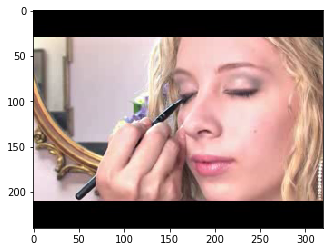

In [32]:
videogen = skvideo.io.vreader(vid_ls[55])

for i, frame in enumerate(videogen):
    #print(i, frame.shape)
    if i == 4:
        print(type(frame))
        print(frame[:, 40:280, :].shape)
        plt.imshow(frame)

In [249]:
def get_frames_npy(vid_path, out_path, length = 7, skip = 2, pre = 1):    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    
    vid_name = os.path.basename(vid_path).split('.')[0]
    videogen = skvideo.io.vreader(vid_path)
    
    frames_lst = [cv2.resize(frame[:, 40:280, :], (256, 256)) 
                  for i, frame in enumerate(videogen) if i%skip == 0]
    
    n = 0
    
    for i in range(int(len(frames_lst)/(length*2))):
        A = np.asarray(frames_lst[i:i+length])
        B = np.asarray(frames_lst[i+length-pre:i+length*2-pre])
        v = np.asarray([A,B])
        v = np.transpose(v , (0,4,1,2,3))
        np.save('{}{}_{}.npy'.format(out_path, vid_name, i),v)

        n += 1
            
    return n

### 超参数输出

In [264]:
npy_path = '/data/dataset/ucf-npy/'
vid_root = '/data/dataset/UCF/'
vid_ls = glob.glob(vid_root+"v_BabyCrawling**.avi")
vid_ls.sort()
total_npy = 0

print('共有视频：{}'.format(len(vid_ls)))

共有视频：132


In [265]:
## Hyperparameter
N = 76 # how many videos would be used
length = 7
skip = 2
pre = 1  

In [267]:
if N == '': N = len(vid_ls)
if N > len(vid_ls): raise ValueError("处理视频数大于视频总数")

with Pool(12) as p:
    p.map(functools.partial(get_frames_npy, 
                            out_path = npy_path, length = length, skip = skip, pre = 1), 
          vid_ls[:N])
    
print(len(os.listdir(npy_path)))

398


## 输出检验

In [268]:
os.listdir(npy_path)

['v_BabyCrawling_g12_c02_4.npy',
 'v_BabyCrawling_g12_c05_5.npy',
 'v_BabyCrawling_g02_c05_2.npy',
 'v_BabyCrawling_g02_c04_0.npy',
 'v_BabyCrawling_g10_c01_2.npy',
 'v_BabyCrawling_g13_c01_1.npy',
 'v_BabyCrawling_g07_c02_3.npy',
 'v_BabyCrawling_g05_c05_2.npy',
 'v_BabyCrawling_g06_c03_3.npy',
 'v_BabyCrawling_g08_c04_0.npy',
 'v_BabyCrawling_g15_c05_2.npy',
 'v_BabyCrawling_g05_c04_0.npy',
 'v_BabyCrawling_g14_c04_4.npy',
 'v_BabyCrawling_g06_c05_3.npy',
 'v_BabyCrawling_g03_c04_2.npy',
 'v_BabyCrawling_g05_c01_6.npy',
 'v_BabyCrawling_g04_c01_2.npy',
 'v_BabyCrawling_g15_c04_1.npy',
 'v_BabyCrawling_g01_c01_4.npy',
 'v_BabyCrawling_g14_c04_0.npy',
 'v_BabyCrawling_g02_c01_2.npy',
 'v_BabyCrawling_g04_c02_2.npy',
 'v_BabyCrawling_g09_c02_0.npy',
 'v_BabyCrawling_g07_c03_5.npy',
 'v_BabyCrawling_g08_c01_4.npy',
 'v_BabyCrawling_g02_c06_5.npy',
 'v_BabyCrawling_g13_c06_3.npy',
 'v_BabyCrawling_g01_c02_0.npy',
 'v_BabyCrawling_g01_c03_0.npy',
 'v_BabyCrawling_g02_c02_2.npy',
 'v_BabyCr

In [269]:
f_t = npy_path+os.listdir(npy_path)[3]
a= np.load(f_t)

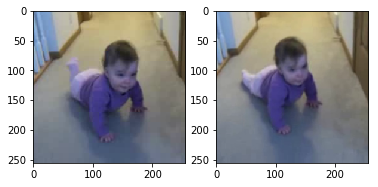

In [270]:
plt.figure(1)
plt.subplot(121)
plt.imshow(np.transpose(a[0], (1,2,3,0))[0])

plt.subplot(122)
plt.imshow(np.transpose(a[1], (1,2,3,0))[0])

In [256]:
rm -rf /data/dataset/ucf-npy/

## images2npy

In [42]:
def get_one_clip(lst,index ,skip ,length  ):
    return lst[index:index+length*skip:skip]

def get_clips(img_lst,skip  ,length):
    clips =[get_one_clip(img_lst,i,skip,length) for i in range(len(img_lst)) if len(get_one_clip(img_lst,i,skip,length)) == length ]
    
    return clips
def get_pair(img_lst,pre ,skip  ,length):
    A = get_clips(img_lst[:][:-pre],skip  ,length)
    B = get_clips(img_lst[pre:],skip  ,length)
    return A,B

read_ = lambda x : cv2.resize(cv2.imread(x)[:, int(1242/2-375/2):int(1242/2+375/2),::-1],(256,256))

def gen_np(c):
#     print(c)
    img1 = [ read_(i)  for i in c[0]]
    img2 = [ read_(i)  for i in c[1]]


    v = np.asarray([img1,img2])
    v = np.transpose(v , (0,4,1,2,3))
#     v.transpose(0,4,1,2,3)
    return v
def dump(img_lst,dirpath='data' ,start =0 ,skip = 2 ,length =7 ,pre =2):

    a,b = get_pair(img_lst,pre ,skip  ,length)
    task = [ (i,j) for i ,j in zip(a,b)]
    for i ,j in enumerate(task):
        v = gen_np(j)
        np.save('{}{}.npy'.format(dirpath,i+start),v)
#         return 
      

In [40]:
def f(data_path):
    start = 0
    img_lst = glob.glob(data_path+"**.png")
    img_lst.sort()
    dump(img_lst,'video/{}{}'.format(*data_path.split('/')[-3:-1]),start,2 ,7 ,2)

In [30]:
f_lst = glob.glob('/data/dataset/depthdata/vkitti_1.3.1_rgb/**/**/')

In [43]:
with Pool(12) as p:
    p.map(f,f_lst)

In [47]:
fi =  'video/000115-deg-left0.npy'
a= np.load(fi)

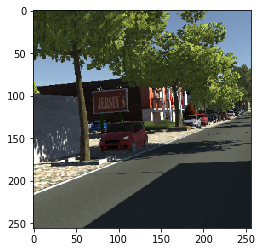

In [50]:
plt.imshow(np.transpose(a[0],(1,2,3,0))[2])

---